# Bringing Customization to Pandas Profiling

If you've previously used pandas-profiling you're probably already aware of it's functionality depends on identifying the type of data being profiled; numeric data gives different summaries from categorical, dates, and so on. Although the logic for identifying types is quite robust it's not well suited to every user or every situation. Until recently, if you wanted to generate a customized report using richer data representations (say you were using shapely geometries, Email Addresses, or explicitly Ordinal data) pandas-profiling was unable to support you.

The recent migration of pandas-profiling to the [visions](https://github.com/dylan-profiler/visions) type system is the first step towards end to end report customization, from summaries to renderings. Over the rest of this blog post I'm going to show you how to easily customize data summaries in pandas-profiling.

# A brief detour into typesets

The default pandas-profiling type system consists of four basic types: 

* Categories
* DateTimes
* Boolean
* Numeric 

Technically, there is a fifth catch-all type called Unsupported for anything that doesn't fit in the others - these are usually complex objects like lists. If you want to inspect it's implementation check out the `ProfilingTypeSet` object found in `pandas_profiling.model.typeset`.

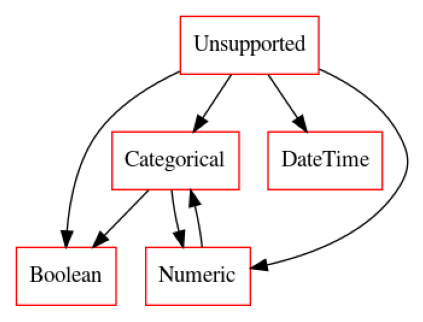

In [1]:
from pandas_profiling.model.typeset import ProfilingTypeSet

typeset = ProfilingTypeSet()
typeset.plot_graph(dpi=100)

NOTE: You'll need to install `pydot` and `pygraphviz` to reproduce these plots

These typesets can be as complicated or simple as your usecase calls for. Want to distinguish between Integers and Floats? URLs from Strings? Images from Files? Something else specific to your data? You can find most of these types pre-built in `visions` and if not writing your own is usually just a few lines of code. A full walkthrough of types and typesystems can be found [here](https://www.ianeaves.com/post/titanic-visions/).

# Customizing Summaries

Let's start with a basic profile report of the titanic dataset.

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df['Survived'] = df['Survived'].astype(bool)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
import pandas_profiling as pp
report = pp.ProfileReport(df, lazy=False, dark_mode=True)
report

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

No surprises here, just our standard pandas-profiling workflow. In addition to the normal html report we can directly inspect the summarization values computed by pandas-profiling through the `description_set` attribute on the report. Let's check out our summary of the `Survived` attribute in particular.

In [4]:
report.description_set['variables']['Survived']

{'n_distinct': 2,
 'p_distinct': 0.002244668911335578,
 'is_unique': False,
 'n_unique': 0,
 'p_unique': 0.0,
 'type': Boolean,
 'hashable': True,
 'value_counts_without_nan': False    549
 True     342
 Name: Survived, dtype: int64,
 'n_missing': 0,
 'n': 891,
 'p_missing': 0.0,
 'count': 891,
 'memory_size': 1019}

There's a lot of useful information here including the memory usage of the series, whether it's values were hashable, and a plethora of summary statistics. 

# Summarizers

Under the hood, `pandas-profiling` uses a `PandasProfilingSummarizer` object to generate all of the summaries we see in the profile report. These summarizers map data types, like Boolean, to a list of summary functions used to create the final summary. 

In [5]:
type(report.summarizer)

pandas_profiling.model.summarizer.PandasProfilingSummarizer

You can reproduce the summary above directly from this summarizer like so:

In [6]:
from pandas_profiling.model.typeset import Boolean
report.summarizer.summarize(df['Survived'], Boolean)

{'n_distinct': 2,
 'p_distinct': 0.002244668911335578,
 'is_unique': False,
 'n_unique': 0,
 'p_unique': 0.0,
 'type': Boolean,
 'hashable': True,
 'value_counts_without_nan': False    549
 True     342
 Name: Survived, dtype: int64,
 'n_missing': 0,
 'n': 891,
 'p_missing': 0.0,
 'count': 891,
 'memory_size': 1019}

Although you can build your own summarizers from scratch, the renderings still rely on the default pandas-profiling data types so it would be difficult to really take advantage of the flexibility offered by `visions`. Let's go ahead and build a summarizer to work a typeset consisting of `Boolean` and `Unsupported` types where we compute the length of each series by default and the probability of being `True` for boolean.

In [14]:
from pandas_profiling.model.summarizer import BaseSummarizer
from pandas_profiling.model.typeset import Unsupported

def default_summary(series: pd.Series, summary: dict = {}):
    summary['length'] = len(series)
    return series, summary

def new_boolean_summary(series: pd.Series, summary: dict = {}):
    summary['probability_true'] = series.mean()
    return series, summary

mapping = {
    Boolean: [default_summary, new_boolean_summary],
    Unsupported: [default_summary]
}
new_typeset = Boolean + Unsupported # In visions, adding two (or more) types together produces a typeset.
summarizer = BaseSummarizer(mapping, new_typeset)

Although this may look complicated, at heart this is just keeping track of a bunch of functions to call on series of different data types. Behind the scenes, the summarizer object took care of composing the summary functions together to produce a final result tacking on a "type" value to track which summarization was used.

In [8]:
summarizer.summarize(df.Survived, Boolean)

{'type': Boolean, 'length': 891, 'probability_true': 0.3838383838383838}

In [9]:
summarizer.summarize(df.Survived, Unsupported)

{'type': Unsupported, 'length': 891}

## Customizing ProfileReport Summaries

Bringing things together, we can now customize the summaries in PandasProfiling pretty much to our hearts content. Rather than building a summarizer entirely from scratch let's start with the default and update the Boolean summary to include our `new_boolean_summary` function.

In [10]:
from pandas_profiling.model.summarizer import PandasProfilingSummarizer

custom_summarizer = PandasProfilingSummarizer(typeset)
custom_summarizer.mapping[Boolean].append(new_boolean_summary)

Now, we tell the ProfileReport to use the new `custom_summarizer` object instead of its default.

In [11]:
report = pp.ProfileReport(df, lazy=False, summarizer=custom_summarizer)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
report.description_set['variables']['Survived']

{'n_distinct': 2,
 'p_distinct': 0.002244668911335578,
 'is_unique': False,
 'n_unique': 0,
 'p_unique': 0.0,
 'type': Boolean,
 'hashable': True,
 'value_counts_without_nan': False    549
 True     342
 Name: Survived, dtype: int64,
 'n_missing': 0,
 'n': 891,
 'p_missing': 0.0,
 'count': 891,
 'memory_size': 1019,
 'probability_true': 0.3838383838383838}

Voila, just like that we were able to insert the `probability_true` calculation into our profile report. In the future this sort of extensibility will be extended to every aspect of a profile report allowing you to remove or add statistics, configure domain specific types, specify your own renderings, and more.